In [ ]:
import torch
import torchvision
torchvision.disable_beta_transforms_warning()
from torchvision.transforms import v2
from torchvision.models import efficientnet_b0,EfficientNet_B0_Weights,densenet121,DenseNet121_Weights
import numpy as np
from tqdm import tqdm
import cv2
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns
import os
import random
import warnings

def set_random_seed(seed: int = 2222, deterministic: bool = False):
        """Set seeds"""
        random.seed(seed)
        np.random.seed(seed)
        os.environ["PYTHONHASHSEED"] = str(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed(seed)  # type: ignore
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = deterministic  # type: ignore

def prep_dataset(path,image_shape=224,augmented_dataset_size=4000
                 ,train_split=0.8,valid_split=0.1,test_split=0.1):

    non_augment_transform=v2.Compose([v2.ToImageTensor(),
                        v2.ToDtype(torch.float32),
                        v2.Resize((image_shape,image_shape),antialias=True),
                        v2.Normalize(mean=[0],std=[1]),
                        ])
    transforms=v2.Compose([v2.ToImageTensor(),
                        v2.ToDtype(torch.float32),
                        v2.RandomAffine(degrees=30,shear=30),
                        v2.RandomZoomOut(side_range=(1,1.5)),
                        v2.Resize((image_shape,image_shape),antialias=True),
                        v2.Normalize(mean=[0],std=[1]),
                        ])
    non_augmented_dataset=torchvision.datasets.ImageFolder(path,transform=non_augment_transform)
    dataset=torchvision.datasets.ImageFolder(path,transform=transforms)
    factor=augmented_dataset_size//len(dataset)

    new_dataset=torch.utils.data.ConcatDataset([non_augmented_dataset]+[dataset for _ in range(factor)])
    del non_augmented_dataset,dataset

    
    #dataset=torchvision.datasets.ImageFolder(path,transform=transforms)
    generator1 = torch.Generator().manual_seed(42)

    return torch.utils.data.random_split(new_dataset, [train_split,valid_split,test_split],
                                                                generator=generator1)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
warnings.filterwarnings("ignore")
n_classes=2
image_shape=224
augmented_dataset_size=4000
    
path="D:\Osteoporosis detection\datasets\Osteoporosis Knee X-ray Dataset Preprocessed"
train_set,valid_set,test_set=prep_dataset(path,image_shape,augmented_dataset_size)
seed=42
set_random_seed(seed)
model_name='conv_next'
print('Model: ',model_name)
#EfficientNetB0 has 16 MBConv layers, freeze till 8th MBConv layer then. Freeze all till before 5th sequential
#DenseNet121 has 58 dense layers, freeze till 29th dense layer then. #Till before dense block 3
if model_name=='efficient':
    model=efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
    p=0.1
    model.classifier[0]=torch.nn.Dropout(p=p,inplace=True)
    model.classifier[-1]=torch.nn.Linear(in_features=1280,out_features=n_classes)

elif model_name=='dense':
    model=densenet121(weights=DenseNet121_Weights.DEFAULT)
    p=0.3
    model.classifier=torch.nn.Sequential(torch.nn.Dropout(p=p,inplace=True),
                                        torch.nn.Linear(in_features=1024,out_features=n_classes),
                                        )

elif 'mobilenet' in model_name:
    model=torchvision.models.mobilenet_v3_small(weights='DEFAULT')
    model.classifier[3]=torch.nn.Linear(in_features=1024,out_features=n_classes)

elif 'conv_next' in model_name:
    p=0.3
    model=torchvision.models.convnext_tiny(weights='DEFAULT')
    model.classifier[2]=torch.nn.Sequential(torch.nn.Dropout(p=p,inplace=True),
                                            torch.nn.Linear(in_features=768,out_features=n_classes),
                                            )

model.load_state_dict(torch.load(f"model/{model_name}best_param.pkl"))

if model_name=='efficient':
    num_features=1280
    model.classifier[-1]=torch.nn.Identity()

elif model_name=='dense':
    num_features=1024
    model.classifier[-1]=torch.nn.Identity()

elif 'mobilenet' in model_name:
    num_features=1024
    model.classifier[-1]=torch.nn.Identity()

elif 'conv_next' in model_name:
    num_features=768
    model.classifier[2][-1]=torch.nn.Identity()

model.eval()
model = model.to(device)

Model:  conv_next


In [13]:
features=np.zeros((len(test_set),num_features))
labels=[]

label_map={0:'normal',1:'osteporosis'}

for i, (image, label) in enumerate(tqdm(test_set)):
    image = image.to(device).unsqueeze(0)
    feat = model(image)

    features[i] = feat.detach().cpu().numpy()
    labels.append(label_map[label])

100%|██████████| 409/409 [00:08<00:00, 46.20it/s]


model_name:  conv_next


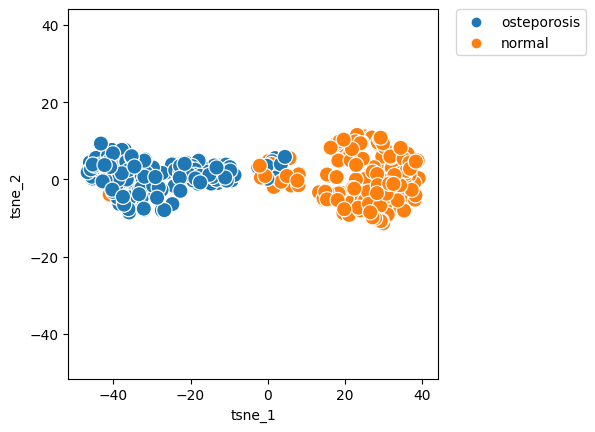

In [14]:
n_components = 2
tsne = TSNE(n_components)
tsne_result = tsne.fit_transform(features)

print("model_name: ", model_name)
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': labels})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

Model:  conv_next


100%|██████████| 409/409 [00:07<00:00, 58.09it/s]


model_name:  conv_next


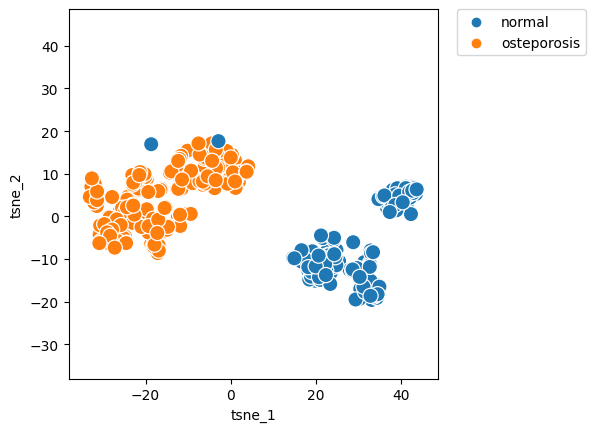

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
warnings.filterwarnings("ignore")
n_classes=2
image_shape=224
augmented_dataset_size=4000
    
path="D:\Osteoporosis detection\datasets\Osteoporosis Knee X-ray modified\Osteoporosis Knee X-ray Preprocessed"
train_set,valid_set,test_set=prep_dataset(path,image_shape,augmented_dataset_size)
seed=42
set_random_seed(seed)
model_name='conv_next'
print('Model: ',model_name)
#EfficientNetB0 has 16 MBConv layers, freeze till 8th MBConv layer then. Freeze all till before 5th sequential
#DenseNet121 has 58 dense layers, freeze till 29th dense layer then. #Till before dense block 3
if model_name=='efficient':
    model=efficientnet_b0(weights=EfficientNet_B0_Weights.DEFAULT)
    p=0.1
    model.classifier[0]=torch.nn.Dropout(p=p,inplace=True)
    model.classifier[-1]=torch.nn.Linear(in_features=1280,out_features=n_classes)

elif model_name=='dense':
    model=densenet121(weights=DenseNet121_Weights.DEFAULT)
    p=0.3
    model.classifier=torch.nn.Sequential(torch.nn.Dropout(p=p,inplace=True),
                                        torch.nn.Linear(in_features=1024,out_features=n_classes),
                                        )

elif 'mobilenet' in model_name:
    model=torchvision.models.mobilenet_v3_small(weights='DEFAULT')
    model.classifier[3]=torch.nn.Linear(in_features=1024,out_features=n_classes)

elif 'conv_next' in model_name:
    p=0.3
    model=torchvision.models.convnext_tiny(weights='DEFAULT')
    model.classifier[2]=torch.nn.Sequential(torch.nn.Dropout(p=p,inplace=True),
                                            torch.nn.Linear(in_features=768,out_features=n_classes),
                                            )

model.load_state_dict(torch.load(f"model/{model_name}_otherbest_param.pkl"))

if model_name=='efficient':
    num_features=1280
    model.classifier[-1]=torch.nn.Identity()

elif model_name=='dense':
    num_features=1024
    model.classifier[-1]=torch.nn.Identity()

elif 'mobilenet' in model_name:
    num_features=1024
    model.classifier[-1]=torch.nn.Identity()

elif 'conv_next' in model_name:
    num_features=768
    model.classifier[2][-1]=torch.nn.Identity()

model.eval()
model = model.to(device)

features=np.zeros((len(test_set),num_features))
labels=[]

label_map={0:'normal',1:'osteporosis'}

for i, (image, label) in enumerate(tqdm(test_set)):
    image = image.to(device).unsqueeze(0)
    feat = model(image)

    features[i] = feat.detach().cpu().numpy()
    labels.append(label_map[label])

n_components = 2
tsne = TSNE(n_components)
tsne_result = tsne.fit_transform(features)

print("model_name: ", model_name)
tsne_result_df = pd.DataFrame({'tsne_1': tsne_result[:,0], 'tsne_2': tsne_result[:,1], 'label': labels})
fig, ax = plt.subplots(1)
sns.scatterplot(x='tsne_1', y='tsne_2', hue='label', data=tsne_result_df, ax=ax,s=120)
lim = (tsne_result.min()-5, tsne_result.max()+5)
ax.set_xlim(lim)
ax.set_ylim(lim)
ax.set_aspect('equal')
ax.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)